# Домашнее задание №1

## Постановка задачи

1. Используется [датасет](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) с данными об одобрении кредитов. Содержит бинарные, категориальные и числовые признаки; также содержит пропущенные данные.
2. Задача - бинарная классификация, целевой признак - последний столбец (A16); показывает - одобрен кредит или нет.
3. Функция потерь - бинарная кроссэнтропия (можно также попробовать Square hinge loss).
4. Метрики оценки качества - accuracy (основная метрика), [ROC AUC score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

### Бинарная кроссэнтропия

$L(y, \hat{y})=-\frac{1}{N}\sum_{i=0}^{N}(y\cdot \log(\hat{y_{i}})+(1-y)\cdot \log(1-\hat{y_{i}}))$,
$y$ - целевое значение, $\hat{y}$ - предсказанное значение.

### Square hinge loss

$L(y, \hat{y})=-\frac{1}{N}\sum_{i=0}^{N}(max(0,1-y_{i}\cdot\hat{y_{i}})^{2})$

In [1]:
import pandas as pd
import time
import numpy as np
import sklearn.preprocessing, sklearn.metrics
import matplotlib.pyplot as plt
import sklearn.model_selection, sklearn.svm
import sklearn.tree, sklearn.ensemble

## Общая информация о датасете

In [2]:
f = open('crx.names')
for line in f:
    print(line)



1. Title: Credit Approval



2. Sources: 

    (confidential)

    Submitted by quinlan@cs.su.oz.au



3.  Past Usage:



    See Quinlan,

    * "Simplifying decision trees", Int J Man-Machine Studies 27,

      Dec 1987, pp. 221-234.

    * "C4.5: Programs for Machine Learning", Morgan Kaufmann, Oct 1992

  

4.  Relevant Information:



    This file concerns credit card applications.  All attribute names

    and values have been changed to meaningless symbols to protect

    confidentiality of the data.

  

    This dataset is interesting because there is a good mix of

    attributes -- continuous, nominal with small numbers of

    values, and nominal with larger numbers of values.  There

    are also a few missing values.

  

5.  Number of Instances: 690



6.  Number of Attributes: 15 + class attribute



7.  Attribute Information:



    A1:	b, a.

    A2:	continuous.

    A3:	continuous.

    A4:	u, y, l, t.

    A5:	g, p, gg.

    A6:	c, d, cc, i, j, k, m, r, q, w, x, 

In [3]:
df = pd.read_csv('crx.data', sep=',', header=None)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


## Замена пропущенных данных (и замена категориальных данных)

In [4]:
cols = list(df.columns)
categoricalCols = [0, 3, 4, 5, 6, 8, 9, 10, 11, 12]
realCols = [x for x in cols if x not in categoricalCols]
dfX = df[cols[:-1]]
dfY = df[cols[-1]]

In [5]:
# создаем массив с местоположением пропущенных данных, формат (i, [j_1, ..., j_n])
missingValueIndices = []
for i in range(len(dfX)):
    if True in set(dfX.iloc[i,:].str.contains('?', regex=False)):
        buf = list(dfX.iloc[i,:].str.contains('?', regex=False))
        xMissingIndices = [i for i, x in enumerate(buf) if x == True]
        missingValueIndices.append((i, xMissingIndices))

In [6]:
# таблица с исключенными строками с пропущенными значениями
dfXFull = dfX.drop([x[0] for x in missingValueIndices])
dfXFull = dfXFull.reset_index(drop=True)

In [7]:
# избавляемся от категориальных признаков в dfXFull и в dfX
# при этом сохраняем энкодеры только для dfXFull, т. к. в них нет ´?´
encoders = []
for col in categoricalCols:
    buf = list(dfXFull[col])
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(buf)
    # print(le.classes_)
    buf = le.transform(buf)
    encoders.append(le)
    dfX.loc[:, col] = dfX[col].replace('?', dfX[col][0])
    bufX = list(dfX[col])
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(bufX)
    bufX = le.transform(bufX)
    dfXFull.loc[:, col] = buf
    dfX.loc[:, col] = bufX
buf = list(dfY)
le = sklearn.preprocessing.LabelEncoder()
le.fit(buf)
buf = le.transform(buf)
dfY = buf
encoders.append(le)

C:\Program Files\WPy-3670\python-3.6.7.amd64\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
# заменяем пропущенные значения значениями из векторов с наименьшим расстоянием между ними
for x in missingValueIndices:
    fullCols = [y for y in cols[:-1] if y not in x[1]]
    bufDf = dfXFull[fullCols]
    vec = list(dfX.iloc[x[0], fullCols])
    dist = sklearn.metrics.pairwise.euclidean_distances([vec], np.array(bufDf))
    simVecIndex = list(dist[0]).index(min(dist[0]))
    for col in x[1]:
        dfX.at[x[0], col] = dfXFull.iloc[simVecIndex, col]

## Нормализация данных

In [9]:
means = []
stds = []
for col in realCols[:-1]:
    bufCol = np.array(dfX.loc[:, col])
    if col in realCols:
        bufCol = list(map(float, bufCol))
        dfX.loc[:, col] = bufCol
    means.append(np.mean(bufCol))
    stds.append(np.std(bufCol))
    dfX.loc[:, col] = [(x - means[-1]) / stds[-1] for x in bufCol]

C:\Program Files\WPy-3670\python-3.6.7.amd64\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
print(means, stds)

[31.72808695652174, 4.758724637681159, 2.223405797101449, 182.58840579710144, 1017.3855072463768] [11.974399653632007, 4.974554575891537, 3.344087470333537, 172.8550079651091, 5206.325792733279]


## Разведочный анализ

In [11]:
for col in categoricalCols:
    print('Признак:', col)
    print('Классы:', list(dfX[col].unique()))
    print('Распределение:', [round(x * 100, 2) for x in list(dfX[col].value_counts(normalize=True))])

Признак: 0
Классы: [1, 0]
Распределение: [68.99, 31.01]
Признак: 3
Классы: [1, 2, 0]
Распределение: [75.94, 23.77, 0.29]
Признак: 4
Классы: [0, 2, 1]
Распределение: [75.94, 23.77, 0.29]
Признак: 5
Классы: [12, 10, 9, 11, 2, 8, 1, 3, 13, 6, 4, 0, 5, 7]
Распределение: [19.86, 11.59, 9.28, 8.55, 7.97, 7.97, 7.54, 6.09, 5.65, 5.51, 4.49, 3.62, 1.45, 0.43]
Признак: 6
Классы: [7, 3, 0, 2, 4, 8, 6, 1, 5]
Распределение: [58.84, 20.0, 8.55, 8.55, 1.16, 1.16, 0.87, 0.58, 0.29]
Признак: 8
Классы: [1, 0]
Распределение: [52.32, 47.68]
Признак: 9
Классы: [1, 0]
Распределение: [57.25, 42.75]
Признак: 10
Классы: [1, 6, 0, 5, 7, 10, 3, 17, 2, 9, 8, 15, 11, 12, 21, 20, 4, 19, 22, 14, 16, 13, 18]
Распределение: [57.25, 10.29, 6.52, 4.06, 3.33, 2.75, 2.61, 2.32, 2.17, 1.45, 1.45, 1.16, 1.16, 1.16, 0.58, 0.43, 0.29, 0.29, 0.14, 0.14, 0.14, 0.14, 0.14]
Признак: 11
Классы: [0, 1]
Распределение: [54.2, 45.8]
Признак: 12
Классы: [0, 2, 1]
Распределение: [90.58, 8.26, 1.16]


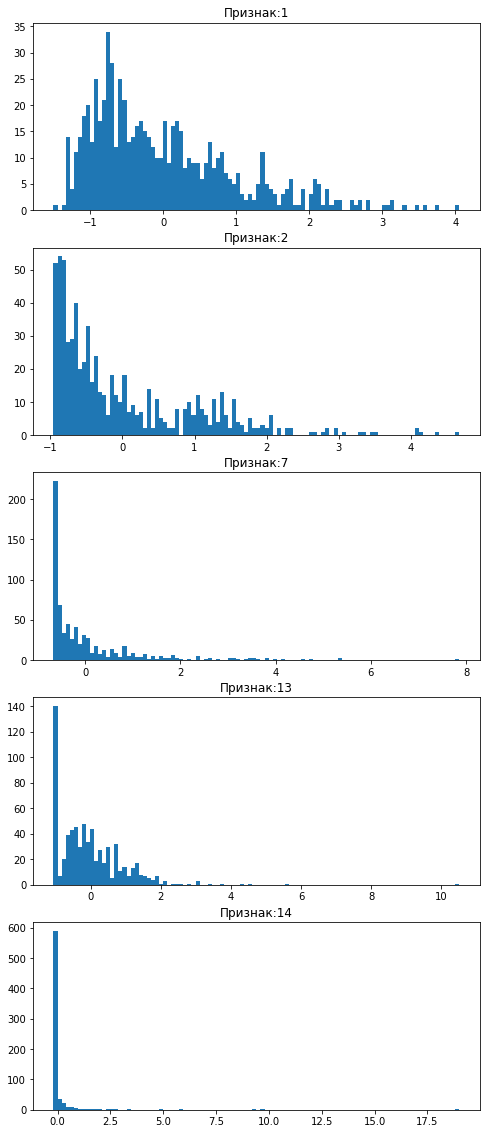

In [12]:
%matplotlib inline
fig, ax = plt.subplots(len(realCols[:-1]), 1, figsize=(8, 20))
for i in range(len(realCols[:-1])):
    # print('Признак:', realCols[i])
    buf = list(dfX[realCols[i]])
    ax[i].hist(buf, bins=100)
    ax[i].set_title('Признак:' + str(realCols[i]))

In [13]:
print('Целевой признак')
# dfY
unique, counts = np.unique(dfY, return_counts=True)
print('Классы:', unique)
print('Распределение:', counts / sum(counts) * 100)

Целевой признак
Классы: [0 1]
Распределение: [44.49275362 55.50724638]


## Выбросы

In [14]:
lower_arr = []
upper_arr = []
out_arr = []
for col in realCols[:-1]:
    buf = np.array(dfX[col])
    q25, q75 = np.percentile(buf, 20), np.percentile(buf, 80)
    cutoff = q75 - q25 * 1.5
    lower, upper = q25 - cutoff, q75 + cutoff
    lower_arr.append(lower)
    upper_arr.append(upper)
    outliers = [i for i in range(len(buf)) if dfX.iloc[i, col] < lower or dfX.iloc[i, col] > upper]
    out_arr.append(outliers)

In [15]:
print(lower_arr, upper_arr)

[-2.854183209461879, -2.9540508064258395, -1.9504898581500358, -3.0394410603463737, -0.4083644292558556] [2.787192467859216, 3.0876408021730635, 1.704739230663928, 2.7746132596763293, 0.13278217189974983]


In [16]:
buf = []
for x in out_arr:
    buf = buf + x
print('Число выбросов:', len(set(buf)))
dfXFiltered = dfX.drop(buf)
dfYFiltered = np.delete(dfY, buf)

Число выбросов: 128


Из-за большого количества выбросов на следующем шаге обучим классификатор на данных без выбросов и на данных с выбросами. По результатам выберем параметры для фильтрации выбросов. Также такое решение обусловлено тем, что судя по графикам и по тому, что данные из области экономики, признаки (числовые) принадлежат распределению с тяжелым хвостом. Следовательно, возникает гипотеза, что данные лучше не выбрасывать.

## SVM

In [17]:
# разбиваем на тестовую и тренировочную выборку
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dfX, dfY, test_size=0.2, random_state=10)
# также делаем разбиение для данных без выбросов
X_train_filt, X_test_filt, y_train_filt, \
y_test_filt = sklearn.model_selection.train_test_split(dfXFiltered,
                                                       dfYFiltered, test_size=0.2, random_state=10)

In [18]:
# функция для подбора параметров классификатора
def chooseBestClf(X_train, X_test, y_train, y_test):
    clf = sklearn.svm.SVC(kernel='linear', gamma='auto', probability=True, random_state=2)
    params = []
    result = []
    params.append({'kernel': ['linear'], 'C': np.arange(1.5, 3.5, 0.2)})
    params.append({'kernel': ['poly'], 'C': np.arange(0.1, 0.3, 0.05),
                   'degree': np.arange(1, 4), 'coef0': np.arange(3, 4, 0.2)})
    params.append({'kernel': ['rbf'], 'C': np.arange(0.6, 2.0, 0.2)})
    params.append({'kernel': ['sigmoid'], 'C': np.arange(0.2, 0.6, 0.1), 'coef0': np.arange(0, 3, 0.5)})
    for param in params:
        gs = sklearn.model_selection.GridSearchCV(clf, param, scoring='roc_auc', cv=5, iid=False)
        gs.fit(X_train, y_train)
        clf.set_params(**gs.best_params_)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)
        acc = sklearn.metrics.accuracy_score(y_test, y_pred)
        y_pred_proba = [y[1] for y in y_pred_proba]
        roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
        result.append([gs.best_params_, acc, roc_auc])
    return result

In [19]:
start = time.time()
res = chooseBestClf(X_train, X_test, y_train, y_test)
end = time.time()
svmCVTime = end - start

In [20]:
# параметры классификатора на данных без фильтрации выбросов
res

[[{'C': 2.5, 'kernel': 'linear'}, 0.9202898550724637, 0.9380252100840336],
 [{'C': 0.15000000000000002,
   'coef0': 3.6000000000000005,
   'degree': 2,
   'kernel': 'poly'},
  0.9202898550724637,
  0.9518907563025211],
 [{'C': 1.2000000000000002, 'kernel': 'rbf'},
  0.782608695652174,
  0.8823529411764706],
 [{'C': 0.4000000000000001, 'coef0': 2.0, 'kernel': 'sigmoid'},
  0.5072463768115942,
  0.6605042016806724]]

In [21]:
res[1][0]['probability'] = True
res[1][0]['random_state'] = 2
res[1][0]['gamma'] = 'auto'
resMetrics = []
clf = sklearn.svm.SVC(**res[1][0])
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
svmTime = end - start
y_pred = clf.predict(X_test)
matr = sklearn.metrics.confusion_matrix(y_test, y_pred)
y_pred_proba = clf.predict_proba(X_test)
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
resMetrics.append([svmCVTime, svmTime, matr, acc, roc_auc])

In [22]:
print(svmCVTime, svmTime)
print(matr, acc, roc_auc)

30.490708827972412 0.05103635787963867
[[62  6]
 [ 5 65]] 0.9202898550724637 0.9518907563025211


In [23]:
start = time.time()
res_filt = chooseBestClf(X_train_filt, X_test_filt, y_train_filt, y_test_filt)
end = time.time()
svmCVTime_filt = end - start

In [24]:
# параметры классификатора на данных с фильтрацией выбросов
res_filt

[[{'C': 1.9, 'kernel': 'linear'}, 0.8938053097345132, 0.9171408250355618],
 [{'C': 0.25000000000000006,
   'coef0': 3.8000000000000007,
   'degree': 2,
   'kernel': 'poly'},
  0.911504424778761,
  0.9377667140825036],
 [{'C': 1.4000000000000004, 'kernel': 'rbf'},
  0.8495575221238938,
  0.9029160739687055],
 [{'C': 0.2, 'coef0': 2.5, 'kernel': 'sigmoid'},
  0.672566371681416,
  0.6625177809388335]]

In [25]:
res_filt[1][0]['probability'] = True
res_filt[1][0]['random_state'] = 2
res_filt[1][0]['gamma'] = 'auto'
resMetrics_filt = []
clf = sklearn.svm.SVC(**res_filt[1][0])
start = time.time()
clf.fit(X_train_filt, y_train_filt)
end = time.time()
svmTime_filt = end - start
y_pred = clf.predict(X_test_filt)
matr = sklearn.metrics.confusion_matrix(y_test_filt, y_pred)
y_pred_proba = clf.predict_proba(X_test_filt)
acc = sklearn.metrics.accuracy_score(y_test_filt, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test_filt, y_pred_proba)
resMetrics_filt.append([svmCVTime_filt, svmTime_filt, matr, acc, roc_auc])

In [26]:
resMetrics_filt

[[23.068422079086304, 0.051035404205322266, array([[35,  2],
         [ 8, 68]], dtype=int64), 0.911504424778761, 0.9377667140825036]]

Лучшие результаты классификатор показывает на данных без фильтрации выбросов, с полиномиальным ядром.

## Случайный лес

Без фильтрации выбросов

In [27]:
def chooseBestTree(X_train, X_test, y_train, y_test):
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=2)
    param = {'criterion': ['gini', 'entropy'], 'max_depth': np.arange(2, 10), 'max_features': range(1, 15, 1),
             'n_estimators': np.arange(150, 201, 50)}
    gs = sklearn.model_selection.GridSearchCV(clf, param, scoring='roc_auc', cv=5, iid=False)
    gs.fit(X_train, y_train)
    clf.set_params(**gs.best_params_)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = [y[1] for y in y_pred_proba]
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
    res = [gs.best_params_, acc, roc_auc]
    return res

In [28]:
start = time.time()
res = chooseBestTree(X_train, X_test, y_train, y_test)
end = time.time()
rfcCVTime = end - start

In [29]:
res

[{'criterion': 'entropy',
  'max_depth': 4,
  'max_features': 4,
  'n_estimators': 200},
 0.8623188405797102,
 0.9569327731092437]

In [30]:
res[0]['random_state'] = 2
clf = sklearn.ensemble.RandomForestClassifier(**res[0])
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
rfcTime = end - start
y_pred = clf.predict(X_test)
matr = sklearn.metrics.confusion_matrix(y_test, y_pred)
y_pred_proba = clf.predict_proba(X_test)
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
resMetrics.append([rfcCVTime, rfcTime, matr, acc, roc_auc])

In [31]:
print(resMetrics)

[[30.490708827972412, 0.05103635787963867, array([[62,  6],
       [ 5, 65]], dtype=int64), 0.9202898550724637, 0.9518907563025211], [645.1480660438538, 0.26818299293518066, array([[52, 16],
       [ 3, 67]], dtype=int64), 0.8623188405797102, 0.9569327731092437]]


С фильтрацией выбросов

In [32]:
def chooseBestTree(X_train, X_test, y_train, y_test):
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=2)
    param = {'criterion': ['gini', 'entropy'], 'max_depth': np.arange(8, 12), 'max_features': range(1, 5, 1),
             'n_estimators': np.arange(190, 221, 10)}
    gs = sklearn.model_selection.GridSearchCV(clf, param, scoring='roc_auc', cv=5, iid=False)
    gs.fit(X_train, y_train)
    clf.set_params(**gs.best_params_)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = [y[1] for y in y_pred_proba]
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
    res = [gs.best_params_, acc, roc_auc]
    return res

In [33]:
start = time.time()
res = chooseBestTree(X_train_filt, X_test_filt, y_train_filt, y_test_filt)
end = time.time()
rfcCVTime_filt = end - start
print(res, rfcCVTime_filt)

[{'criterion': 'entropy', 'max_depth': 9, 'max_features': 2, 'n_estimators': 200}, 0.9026548672566371, 0.9576813655761024] 163.9601857662201


In [34]:
res[0]['random_state'] = 2
# resMetrics_filt = []
clf = sklearn.ensemble.RandomForestClassifier(**res[0])
start = time.time()
clf.fit(X_train_filt, y_train_filt)
end = time.time()
rfcTime_filt = end - start
y_pred = clf.predict(X_test_filt)
matr = sklearn.metrics.confusion_matrix(y_test_filt, y_pred)
y_pred_proba = clf.predict_proba(X_test_filt)
acc = sklearn.metrics.accuracy_score(y_test_filt, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test_filt, y_pred_proba)
resMetrics_filt.append([rfcCVTime_filt, rfcTime_filt, matr, acc, roc_auc])

## Boosting

Без фильтрации выбросов

In [35]:
def chooseBestParams(X_train, X_test, y_train, y_test):
    clf = sklearn.ensemble.AdaBoostClassifier(learning_rate=0.9, random_state=2)
    est1 = sklearn.tree.DecisionTreeClassifier(max_depth=10, random_state=2)
    est2 = sklearn.svm.SVC(kernel='poly', degree=2, gamma='auto', probability=True)
    param = {'base_estimator': [est1], 'base_estimator__max_depth': np.arange(5, 11),
             'base_estimator__max_features': range(3, 15, 2),
             'learning_rate': np.arange(0.8, 0.92, 0.02), 'n_estimators': np.arange(80, 151, 10)}
    gs = sklearn.model_selection.GridSearchCV(clf, param, scoring='roc_auc', cv=5, iid=False)
    gs.fit(X_train, y_train)
    clf.set_params(**gs.best_params_)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = [y[1] for y in y_pred_proba]
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
    res = [gs.best_params_, acc, roc_auc]
    return res

In [36]:
start = time.time()
res = chooseBestParams(X_train, X_test, y_train, y_test)
end = time.time()
abcCVTime = end - start
print(res)

[{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2, splitter='best'), 'base_estimator__max_depth': 6, 'base_estimator__max_features': 5, 'learning_rate': 0.8800000000000001, 'n_estimators': 150}, 0.8333333333333334, 0.9258403361344537]


In [37]:
print(abcCVTime)

2374.273901462555


In [38]:
res[0]['random_state'] = 2
del res[0]['base_estimator__max_depth']
del res[0]['base_estimator__max_features']
clf = sklearn.ensemble.AdaBoostClassifier(**res[0])
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
abcTime = end - start
y_pred = clf.predict(X_test)
matr = sklearn.metrics.confusion_matrix(y_test, y_pred)
y_pred_proba = clf.predict_proba(X_test)
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
resMetrics.append([abcCVTime, abcTime, matr, acc, roc_auc])

In [39]:
print(resMetrics)

[[30.490708827972412, 0.05103635787963867, array([[62,  6],
       [ 5, 65]], dtype=int64), 0.9202898550724637, 0.9518907563025211], [645.1480660438538, 0.26818299293518066, array([[52, 16],
       [ 3, 67]], dtype=int64), 0.8623188405797102, 0.9569327731092437], [2374.273901462555, 0.33224964141845703, array([[48, 20],
       [ 3, 67]], dtype=int64), 0.8333333333333334, 0.9258403361344537]]


С фильтрацией выбросов

In [40]:
def chooseBestParams(X_train, X_test, y_train, y_test):
    clf = sklearn.ensemble.AdaBoostClassifier(learning_rate=0.9, random_state=2)
    est1 = sklearn.tree.DecisionTreeClassifier(max_depth=10, random_state=2)
    est2 = sklearn.svm.SVC(kernel='poly', degree=2, gamma='auto', probability=True)
    param = {'base_estimator': [est1], 'base_estimator__max_depth': np.arange(7, 10),
             'base_estimator__max_features': range(1, 6, 1),
             'learning_rate': np.arange(0.8, 0.92, 0.02), 'n_estimators': np.arange(20, 91, 10)}
    gs = sklearn.model_selection.GridSearchCV(clf, param, scoring='roc_auc', cv=5, iid=False)
    gs.fit(X_train, y_train)
    clf.set_params(**gs.best_params_)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = [y[1] for y in y_pred_proba]
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
    res = [gs.best_params_, acc, roc_auc]
    return res

In [41]:
start = time.time()
res = chooseBestParams(X_train_filt, X_test_filt, y_train_filt, y_test_filt)
end = time.time()
abcCVTime_filt = end - start
print(res)

[{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2, splitter='best'), 'base_estimator__max_depth': 8, 'base_estimator__max_features': 3, 'learning_rate': 0.8800000000000001, 'n_estimators': 80}, 0.8584070796460177, 0.933854907539118]


In [42]:
res[0]['random_state'] = 2
del res[0]['base_estimator__max_depth']
del res[0]['base_estimator__max_features']
clf = sklearn.ensemble.AdaBoostClassifier(**res[0])
start = time.time()
clf.fit(X_train_filt, y_train_filt)
end = time.time()
abcTime_filt = end - start
y_pred = clf.predict(X_test_filt)
matr = sklearn.metrics.confusion_matrix(y_test_filt, y_pred)
y_pred_proba = clf.predict_proba(X_test_filt)
acc = sklearn.metrics.accuracy_score(y_test_filt, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test_filt, y_pred_proba)
resMetrics_filt.append([abcCVTime_filt, abcTime_filt, matr, acc, roc_auc])

## Результаты

Конфигурация компьютера: Intel Core i5-4210U, 8GB RAM

In [43]:
res_columns = ['Grid search time, s', 'Training time, s', 'Accuracy', 'ROC-AUC']
res_indices = ['SVM', 'RandomForest', 'AdaBoost', 'SVMFilt','RandomForestFilt', 'AdaBoostFilt']
resMetr = np.vstack([np.array(resMetrics), np.array(resMetrics_filt)])

result_df = pd.DataFrame(resMetr[:, [0, 1, 3, 4]], index=res_indices, columns=res_columns)
result_df

,"Grid search time, s","Training time, s",Accuracy,ROC-AUC
SVM,30.4907,0.0510364,0.92029,0.951891
RandomForest,645.148,0.268183,0.862319,0.956933
AdaBoost,2374.27,0.33225,0.833333,0.92584
SVMFilt,23.0684,0.0510354,0.911504,0.937767
RandomForestFilt,163.96,0.257183,0.902655,0.957681
AdaBoostFilt,375.902,0.156113,0.858407,0.933855


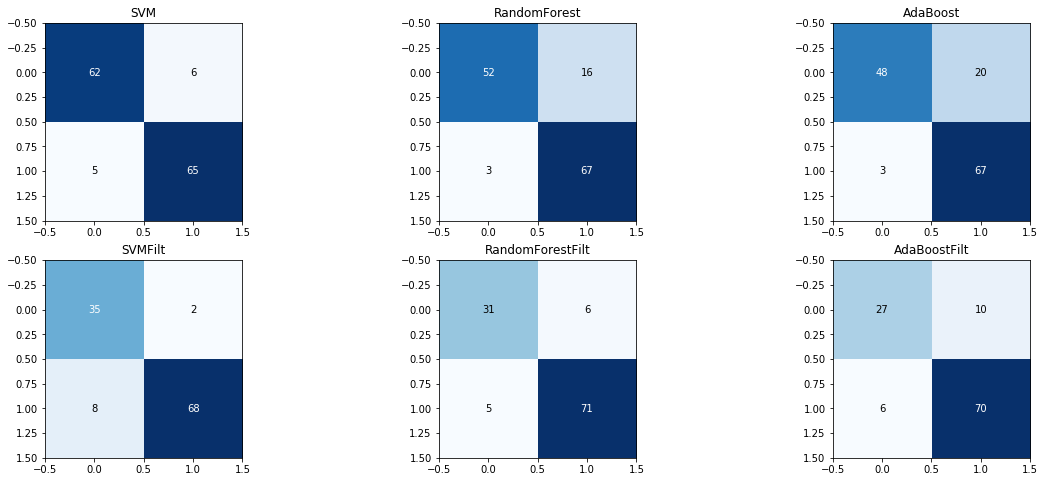

In [46]:
%matplotlib inline
matrices = resMetr[:, [2]]
fig, ax = plt.subplots(2, 3, figsize=(20, 8))
for m in range(2):
    for i in range(3):
        # print('Признак:', realCols[i])
        # buf = list(dfX[realCols[i]])
        # print(matrices[i][0])
        ax[m][i].imshow(matrices[i + m * 3][0], interpolation='nearest', cmap=plt.cm.Blues)
        cm = matrices[i + m * 3][0]
        normalize = False
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for k in range(2):
            for j in range(2):
                ax[m][i].text(j, k, format(cm[k][j], fmt),
                        ha="center", va="center",
                        color="white" if cm[k, j] > thresh else "black")
        ax[m][i].set_title(res_indices[i + m * 3])

По результатам применения различных алгоритмов можно сказать, что на данном датасете лучше всего работает метод опорных векторов с полиномиальным ядром. При этом также можно заметить, что случайный лес и AdaBoost лучше работают на данных с отфильтрованными выбросами, а SVM лучше работает без фильтрации выбросов.